In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import requests as req
import json
import multiprocessing as mp


from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

new_path = os.getcwd().replace('/notebooks', '')
print(f'Adding {new_path} to sys.path')

if new_path not in sys.path:
    sys.path.append(new_path)

plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 10})

# Local imports
from curvemetrics.src.classes.datahandler import DataHandler
from curvemetrics.src.classes.datafetcher import DataFetcher
from curvemetrics.src.classes.metricsprocessor import MetricsProcessor
from curvemetrics.src.plotting.plot import bocd_plot_comp
from curvemetrics.src.classes.model import BOCD

Adding /root/curve-lp-metrics to sys.path


In [24]:
datahandler = DataHandler()
token_metadata = datahandler.get_token_metadata()
pool_metadata = datahandler.get_pool_metadata()
metricsprocessor = MetricsProcessor(pool_metadata, token_metadata, freq='1h')

In [25]:
{k: v['name'] for k, v in pool_metadata.items()}

{'0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7': 'Curve.fi DAI/USDC/USDT',
 '0xdc24316b9ae028f1497c275eb9192a3ea0f67022': 'Curve.fi ETH/stETH',
 '0xdcef968d416a41cdac0ed8702fac8128a64241a2': 'Curve.fi FRAX/USDC',
 '0xceaf7747579696a2f0bb206a14210e3c9e6fb269': 'Curve.fi Factory USD Metapool: wormhole v2 UST-3Pool',
 '0x0f9cb53ebe405d49a0bbdbd291a65ff571bc83e1': 'Curve.fi USDN/3Crv',
 '0x5a6a4d54456819380173272a5e8e9b9904bdf41b': 'Curve.fi Factory USD Metapool: Magic Internet Money 3Pool',
 '0xa5407eae9ba41422680e2e00537571bcc53efbfd': 'Curve.fi DAI/USDC/USDT/sUSD',
 '0xa1f8a6807c402e4a15ef4eba36528a3fed24e577': 'Curve.fi ETH/frxETH',
 '0xed279fdd11ca84beef15af5d39bb4d4bee23f0ca': 'Curve.fi Factory USD Metapool: Liquity',
 '0x4807862aa8b2bf68830e4c8dc86d0e9a998e085a': 'Curve.fi Factory USD Metapool: Binance USD',
 '0x828b154032950c8ff7cf8085d841723db2696056': 'Curve.fi Factory Plain Pool: stETH concentrated',
 '0x5fae7e604fc3e24fd43a72867cebac94c65b404a': 'Curve.fi Factory Crypto Pool: cbE

In [3]:
# swaps_data = datahandler.get_swaps_data(pool, start_ts, end_ts)
# lp_data = datahandler.get_lp_data(pool, start_ts, end_ts)
# pool_data = datahandler.get_pool_data(pool, start_ts, end_ts)
# snapshots = datahandler.get_pool_snapshots(pool, start_ts, end_ts)

# ohlcvs = {}
# for token in set(swaps_data['tokenBought']):
#     ohlcv = datahandler.get_ohlcv_data(token, start=start_ts, end=end_ts)
#     if token == "0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2":
#         token = "0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee"
#     ohlcvs[token] = ohlcv

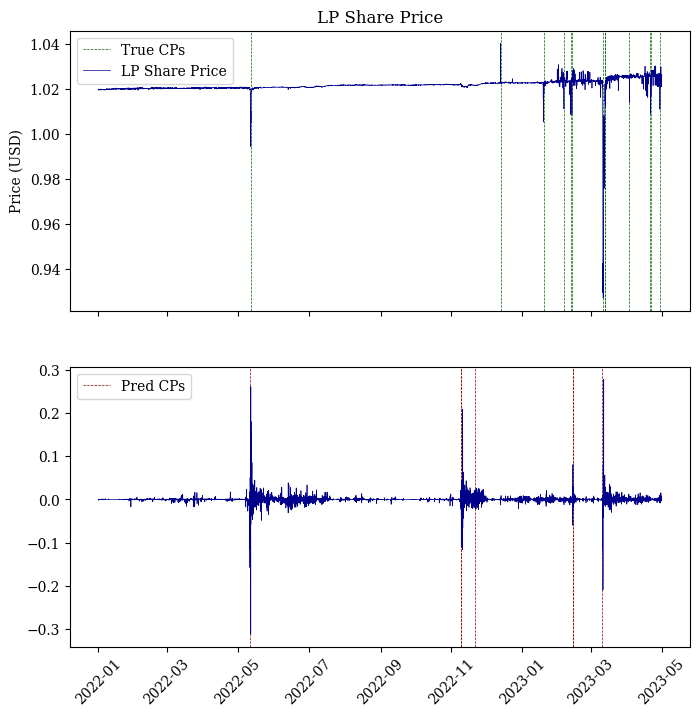

In [63]:
FREQ = '1h'
pool = "0xbebc44782c7db0a1a60cb6fe97d0b483032ff1c7" 
metric = 'shannonsEntropy'

start_ts, start_block = DataFetcher.get_block(datetime.fromisoformat("2022-01-01"))
end_ts, end_block = DataFetcher.get_block(datetime.fromisoformat("2023-05-01"))

lp_share_price = datahandler.get_pool_metric(pool, 'lpSharePrice', start_ts, end_ts).resample(FREQ).mean()
snapshots = datahandler.get_pool_snapshots(pool, start_ts, end_ts)
virtual_price = snapshots['virtualPrice'].resample(FREQ).mean() / 10**18
y = metricsprocessor.true_cps(lp_share_price, virtual_price, thresh=0.01)

X = datahandler.get_X(metric, pool, start_ts, end_ts, FREQ)

model = BOCD(margin=timedelta(hours=24), alpha=1/5, verbose=True)
model.update({'alpha':0.1, 'beta':0.1, 'kappa':0.1})
y_pred = model.predict(X)

bocd_plot_comp(X, lp_share_price, y, y_pred, show=True)

In [64]:
y_pred

DatetimeIndex(['2022-05-11 13:00:00', '2022-11-09 10:00:00',
               '2022-11-09 12:00:00', '2022-11-21 04:00:00',
               '2023-02-13 10:00:00', '2023-02-13 19:00:00',
               '2023-03-10 21:00:00'],
              dtype='datetime64[ns]', name='timestamp', freq=None)

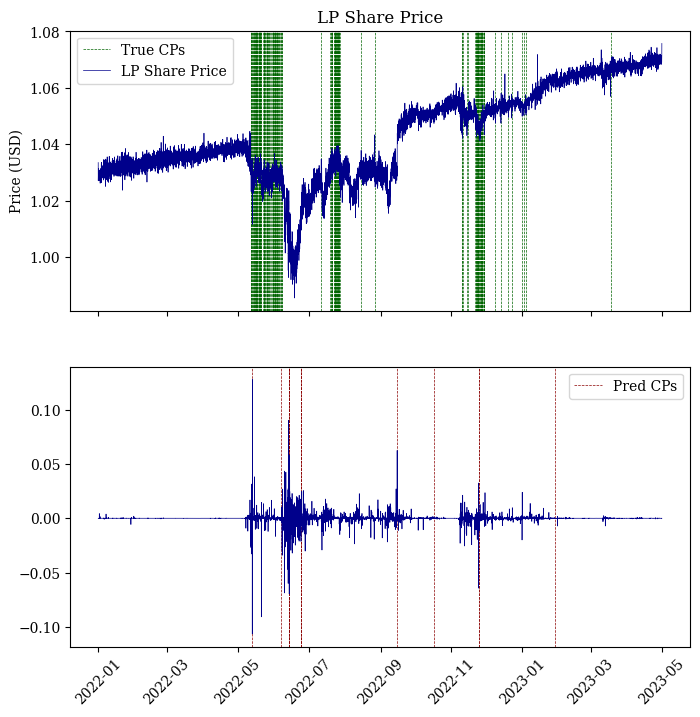

In [60]:
FREQ = '1h'
pool = "0xdc24316b9ae028f1497c275eb9192a3ea0f67022" 
metric = 'shannonsEntropy'

start_ts, start_block = DataFetcher.get_block(datetime.fromisoformat("2022-01-01"))
end_ts, end_block = DataFetcher.get_block(datetime.fromisoformat("2023-05-01"))

eth = '0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee'
steth = '0xae7ab96520de3a18e5e111b5eaab095312d7fe84'
eth_price = datahandler.get_ohlcv_data(eth, start=start_ts, end=end_ts)['close'].resample(FREQ).mean()
steth_price = datahandler.get_ohlcv_data(steth, start=start_ts, end=end_ts)['close'].resample(FREQ).mean()

lp_share_price = datahandler.get_pool_metric(pool, 'lpSharePrice', start_ts, end_ts).resample(FREQ).mean() / eth_price
snapshots = datahandler.get_pool_snapshots(pool, start_ts, end_ts)
virtual_price = snapshots['virtualPrice'].resample(FREQ).mean() / 10**18
y = metricsprocessor.true_cps(lp_share_price, virtual_price, thresh=0.01)

X = datahandler.get_X(metric, pool, start_ts, end_ts, FREQ)

model = BOCD(margin=timedelta(hours=24), alpha=1/5, verbose=True)
model.update({'alpha':0.1, 'beta':0.1, 'kappa':0.1})
y_pred = model.predict(X)

bocd_plot_comp(X, lp_share_price, y, y_pred, show=True)

# Train BOCD on UST Depeg

Using Shannon's Entropy

In [4]:
pool = "0xceaf7747579696a2f0bb206a14210e3c9e6fb269" 

start_ts, start_block = DataFetcher.get_block(datetime.fromisoformat("2022-01-01"))
end_ts, end_block = DataFetcher.get_block(datetime.fromisoformat("2022-06-01"))

shannon = datahandler.get_pool_metric(pool, 'shannonsEntropy', start_ts, end_ts)
lp_share_price = datahandler.get_pool_metric(pool, 'lpSharePrice', start_ts, end_ts)
y = datahandler.get_changepoints(pool, 'baseline', 'baseline', start_ts, end_ts).index

In [5]:
alpha = [10**i for i in range(0, 4)]
beta = [10**i for i in range(-3, 0)]
kappa = [10**i for i in range(-3, 0)]

grid = [[a, b, k] for a in alpha for b in beta for k in kappa]
print(f'Training grid of length: {len(grid)}')

Training grid of length: 36


In [6]:
freq = '1h'
X = np.log1p(shannon.resample(freq).last().pct_change()).dropna()
port = lp_share_price.resample(freq).last()

bocd = BOCD(alpha=1/2, verbose=True)
bocd.tune(grid, X, y)

params = bocd.best_params
results = bocd.best_results
print(f'Best Results: {results}')
print(f'Best Params: {params}')

y_pred = bocd.y_pred
bocd_plot_comp(X, port, y, y_pred)

Processing 9 chunks of length 4; 8 cpus.



Processed 223 of 3520ocessed 1 of 3520Processed 6 of 3520Processed 3 of 3520Processed 1 of 3520Processed 2 of 3520Processed 9 of 3520Processed 3 of 3520Processed 2 of 3520Processed 3 of 3520Processed 1 of 3520Processed 11 of 3520Processed 6 of 3520Processed 4 of 3520Processed 5 of 3520Processed 3 of 3520Processed 6 of 3520Processed 1 of 3520Processed 4 of 3520Processed 2 of 3520Processed 14 of 3520Processed 3 of 3520Processed 9 of 3520Processed 2 of 3520Processed 16 of 3520Processed 1 of 3520Processed 15 of 3520Processed 8 of 3520Processed 7 of 3520Processed 11 of 3520Processed 12 of 3520Processed 6 of 3520Processed 9 of 3520Processed 13 of 3520Processed 10 of 3520Processed 5 of 3520Processed 7 of 3520Processed 2 of 3520Processed 18 of 3520Processed 6 of 3520Processed 11 of 3520Processed 14 of 3520Processed 19 of 3520Processed 9 of 3520Processed 12 of 3520Processed 13 of 3520Processed 8 of 3520Processed 20 of 3520Processed 9 of 3520Processed 16 of 3520Processed 21 of 3520Processed 14 o

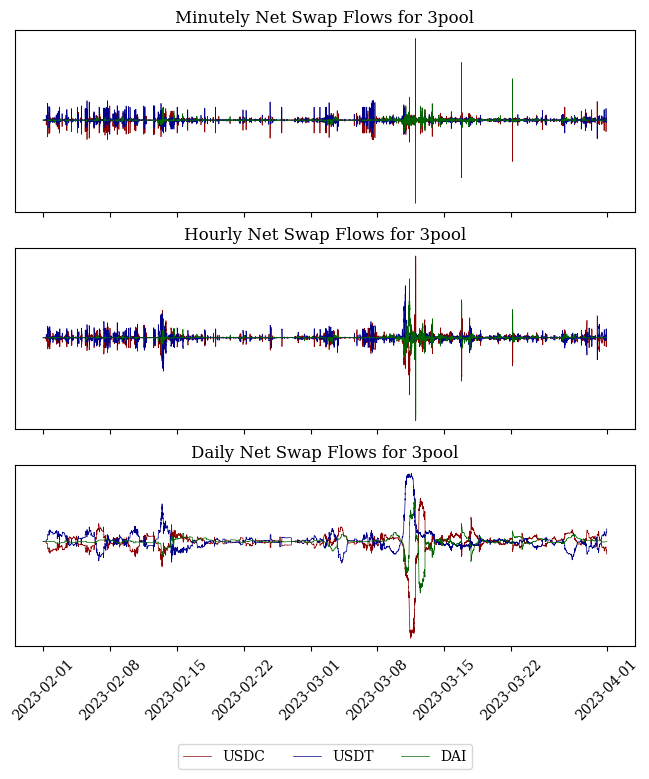

In [87]:
f, axs = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

titles = ['Minutely', 'Hourly', 'Daily']
freqs = ['1min', '1h', '1d']

for i, ax in enumerate(axs):

    usdc_flow = pool_metrics['USDC.netSwapFlow'].rolling(freqs[i]).sum() / 1e6
    usdt_flow = pool_metrics['USDT.netSwapFlow'].rolling(freqs[i]).sum() / 1e6
    dai_flow = pool_metrics['DAI.netSwapFlow'].rolling(freqs[i]).sum() / 1e6

    ax.plot(usdc_flow.index, usdc_flow, label='USDC', linewidth=0.5, c='darkred')
    ax.plot(usdt_flow.index, usdt_flow, label='USDT', linewidth=0.5, c='darkblue')
    ax.plot(dai_flow.index, dai_flow, label='DAI', linewidth=0.5, c='darkgreen')

    # ax.grid(True)
    ax.set_title(f'{titles[i]} Net Swap Flows for 3pool')
    ax.set_yticks([])
    
ax.tick_params(axis='x', rotation=45)
axs[-1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.5), ncol=3)
f.savefig('../figs/3pool_swap_flows.png', bbox_inches='tight')

# Grid Search

In [71]:
# alpha = [10**i for i in range(1, 5)]
# beta = [10**i for i in range(-5, -1)]
# kappa = [10**i for i in range(-5, -1)]

alpha = [10000]
beta = [1e-5]
kappa = [0.01]

grid = [[a, b, k] for a in alpha for b in beta for k in kappa]
print(len(grid))

1


In [92]:
freq = '1h'
X = np.log1p(shannon.pct_change()).dropna().resample(freq).mean()
port = lp_share_price.resample(freq).mean()

bocd = BOCD()
results = bocd.tune(grid, X, y.index)


Finished tuning hyperparameters

Results: {(10000, 1e-05, 0.01): (0.16666666666666666, 0.03926701570680628, 0.8823529411764706)}
Best Params: (10000, 1e-05, 0.01)
FPR: (0.16666666666666666, 0.03926701570680628, 0.8823529411764706)
Predicted CPs: DatetimeIndex(['2023-01-01 05:00:00', '2023-01-01 06:00:00',
               '2023-01-01 17:00:00', '2023-01-01 19:00:00',
               '2023-01-02 00:00:00', '2023-01-02 01:00:00',
               '2023-01-02 08:00:00', '2023-01-02 09:00:00',
               '2023-01-02 16:00:00', '2023-01-02 18:00:00',
               ...
               '2023-04-26 22:00:00', '2023-04-28 21:00:00',
               '2023-04-29 02:00:00', '2023-04-29 04:00:00',
               '2023-04-29 05:00:00', '2023-04-29 06:00:00',
               '2023-04-30 04:00:00', '2023-04-30 05:00:00',
               '2023-04-30 15:00:00', '2023-04-30 21:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=382, freq=None)



timestamp
2023-01-19 04:01:00    1674100860
2023-02-03 21:52:00    1675461120
2023-03-11 04:31:00    1678509060
2023-03-11 04:36:00    1678509360
2023-03-11 04:45:00    1678509900
2023-03-11 05:48:00    1678513680
2023-03-11 05:58:00    1678514280
2023-03-11 07:04:00    1678518240
2023-03-11 17:32:00    1678555920
2023-03-11 17:53:00    1678557180
2023-03-11 18:18:00    1678558680
2023-03-12 08:05:00    1678608300
2023-03-12 08:08:00    1678608480
2023-03-12 08:13:00    1678608780
2023-03-12 08:17:00    1678609020
2023-03-12 08:20:00    1678609200
2023-03-12 08:33:00    1678609980
Name: changepoints, dtype: int64

In [5]:
alpha = 1/5
P = 0.12790697674418605
R = 0.7333333333333333
F = P * R / (alpha * R + (1 - alpha) * P)
F

0.37671232876712324

In [1]:
bar = {(0.1, 1e-05, 1e-05): (0, 0.0, 0.0), (0.1, 1e-05, 0.0001): (0, 0.0, 0.0), (0.1, 1e-05, 0.001): (0, 0.0, 0.0), (0.1, 1e-05, 0.01): (0, 0.0, 0.0), (0.1, 1e-05, 0.1): (0, 0.0, 0.0), (0.1, 1e-05, 1): (0, 0.0, 0.0), (0.1, 0.0001, 1e-05): (0, 0, 0), (0.1, 0.0001, 0.0001): (0, 0, 0), (0.1, 0.0001, 0.001): (0, 0, 0), (0.1, 0.0001, 0.01): (0, 0, 0), (0.1, 0.0001, 0.1): (0, 0, 0), (0.1, 0.0001, 1): (0, 0, 0), (0.1, 0.001, 1e-05): (0, 0, 0), (0.1, 0.001, 0.0001): (0, 0, 0), (0.1, 0.001, 0.001): (0, 0, 0), (0.1, 0.001, 0.01): (0, 0, 0), (0.1, 0.001, 0.1): (0, 0, 0), (0.1, 0.001, 1): (0, 0, 0), (0.1, 0.01, 1e-05): (0, 0, 0), (0.1, 0.01, 0.0001): (0, 0, 0), (0.1, 0.01, 0.001): (0, 0, 0), (0.1, 0.01, 0.01): (0, 0, 0), (0.1, 0.01, 0.1): (0, 0, 0), (0.1, 0.01, 1): (0, 0, 0), (0.1, 0.1, 1e-05): (0, 0, 0), (0.1, 0.1, 0.0001): (0, 0, 0), (0.1, 0.1, 0.001): (0, 0, 0), (0.1, 0.1, 0.01): (0, 0, 0), (0.1, 0.1, 0.1): (0, 0, 0), (0.1, 0.1, 1): (0, 0, 0), (0.1, 1, 1e-05): (0, 0, 0), (0.1, 1, 0.0001): (0, 0, 0), (0.1, 1, 0.001): (0, 0, 0), (0.1, 1, 0.01): (0, 0, 0), (0.1, 1, 0.1): (0, 0, 0), (0.1, 1, 1): (0, 0, 0), (1, 1e-05, 1e-05): (0, 0.0, 0.0), (1, 1e-05, 0.0001): (0, 0.0, 0.0), (1, 1e-05, 0.001): (0, 0.0, 0.0), (1, 1e-05, 0.01): (0, 0.0, 0.0), (1, 1e-05, 0.1): (0, 0.0, 0.0), (1, 1e-05, 1): (0, 0.0, 0.0), (1, 0.0001, 1e-05): (0, 0, 0), (1, 0.0001, 0.0001): (0, 0, 0), (1, 0.0001, 0.001): (0, 0, 0), (1, 0.0001, 0.01): (0, 0, 0), (1, 0.0001, 0.1): (0, 0, 0), (1, 0.0001, 1): (0, 0, 0), (1, 0.001, 1e-05): (0, 0, 0), (1, 0.001, 0.0001): (0, 0, 0), (1, 0.001, 0.001): (0, 0, 0), (1, 0.001, 0.01): (0, 0, 0), (1, 0.001, 0.1): (0, 0, 0), (1, 0.001, 1): (0, 0, 0), (1, 0.01, 1e-05): (0, 0, 0), (1, 0.01, 0.0001): (0, 0, 0), (1, 0.01, 0.001): (0, 0, 0), (1, 0.01, 0.01): (0, 0, 0), (1, 0.01, 0.1): (0, 0, 0), (1, 0.01, 1): (0, 0, 0), (1, 0.1, 1e-05): (0, 0, 0), (1, 0.1, 0.0001): (0, 0, 0), (1, 0.1, 0.001): (0, 0, 0), (1, 0.1, 0.01): (0, 0, 0), (1, 0.1, 0.1): (0, 0, 0), (1, 0.1, 1): (0, 0, 0), (1, 1, 1e-05): (0, 0, 0), (1, 1, 0.0001): (0, 0, 0), (1, 1, 0.001): (0, 0, 0), (1, 1, 0.01): (0, 0, 0), (1, 1, 0.1): (0, 0, 0), (1, 1, 1): (0, 0, 0), (10, 1e-05, 1e-05): (0, 0.0, 0.0), (10, 1e-05, 0.0001): (0, 0.0, 0.0), (10, 1e-05, 0.001): (0, 0.0, 0.0), (10, 1e-05, 0.01): (0, 0.0, 0.0), (10, 1e-05, 0.1): (0, 0.0, 0.0), (10, 1e-05, 1): (0, 0.0, 0.0), (10, 0.0001, 1e-05): (0, 0, 0), (10, 0.0001, 0.0001): (0, 0, 0), (10, 0.0001, 0.001): (0, 0, 0), (10, 0.0001, 0.01): (0, 0, 0), (10, 0.0001, 0.1): (0, 0, 0), (10, 0.0001, 1): (0, 0, 0), (10, 0.001, 1e-05): (0, 0, 0), (10, 0.001, 0.0001): (0, 0, 0), (10, 0.001, 0.001): (0, 0, 0), (10, 0.001, 0.01): (0, 0, 0), (10, 0.001, 0.1): (0, 0, 0), (10, 0.001, 1): (0, 0, 0), (10, 0.01, 1e-05): (0, 0, 0), (10, 0.01, 0.0001): (0, 0, 0), (10, 0.01, 0.001): (0, 0, 0), (10, 0.01, 0.01): (0, 0, 0), (10, 0.01, 0.1): (0, 0, 0), (10, 0.01, 1): (0, 0, 0), (10, 0.1, 1e-05): (0, 0, 0), (10, 0.1, 0.0001): (0, 0, 0), (10, 0.1, 0.001): (0, 0, 0), (10, 0.1, 0.01): (0, 0, 0), (10, 0.1, 0.1): (0, 0, 0), (10, 0.1, 1): (0, 0, 0), (10, 1, 1e-05): (0, 0, 0), (10, 1, 0.0001): (0, 0, 0), (10, 1, 0.001): (0, 0, 0), (10, 1, 0.01): (0, 0, 0), (10, 1, 0.1): (0, 0, 0), (10, 1, 1): (0, 0, 0), (100, 1e-05, 1e-05): (0, 0.0, 0.0), (100, 1e-05, 0.0001): (0, 0.0, 0.0), (100, 1e-05, 0.001): (0, 0.0, 0.0), (100, 1e-05, 0.01): (0, 0.0, 0.0), (100, 1e-05, 0.1): (0, 0.0, 0.0), (100, 1e-05, 1): (0, 0.0, 0.0), (100, 0.0001, 1e-05): (0, 0, 0), (100, 0.0001, 0.0001): (0, 0, 0), (100, 0.0001, 0.001): (0, 0, 0), (100, 0.0001, 0.01): (0, 0, 0), (100, 0.0001, 0.1): (0, 0, 0), (100, 0.0001, 1): (0, 0.0, 0.0), (100, 0.001, 1e-05): (0, 0, 0), (100, 0.001, 0.0001): (0, 0, 0), (100, 0.001, 0.001): (0, 0, 0), (100, 0.001, 0.01): (0, 0, 0), (100, 0.001, 0.1): (0, 0, 0), (100, 0.001, 1): (0, 0, 0), (100, 0.01, 1e-05): (0, 0, 0), (100, 0.01, 0.0001): (0, 0, 0), (100, 0.01, 0.001): (0, 0, 0), (100, 0.01, 0.01): (0, 0, 0), (100, 0.01, 0.1): (0, 0, 0), (100, 0.01, 1): (0, 0, 0), (100, 0.1, 1e-05): (0, 0, 0), (100, 0.1, 0.0001): (0, 0, 0), (100, 0.1, 0.001): (0, 0, 0), (100, 0.1, 0.01): (0, 0, 0), (100, 0.1, 0.1): (0, 0, 0), (100, 0.1, 1): (0, 0, 0), (100, 1, 1e-05): (0, 0, 0), (100, 1, 0.0001): (0, 0, 0), (100, 1, 0.001): (0, 0, 0), (100, 1, 0.01): (0, 0, 0), (100, 1, 0.1): (0, 0, 0), (100, 1, 1): (0, 0, 0), (1000, 1e-05, 1e-05): (0, 0.0, 0.0), (1000, 1e-05, 0.0001): (0, 0.0, 0.0), (1000, 1e-05, 0.001): (0, 0.0, 0.0), (1000, 1e-05, 0.01): (0, 0.0, 0.0), (1000, 1e-05, 0.1): (0, 0.0, 0.0), (1000, 1e-05, 1): (0, 0.0, 0.0), (1000, 0.0001, 1e-05): (0, 0.0, 0.0), (1000, 0.0001, 0.0001): (0, 0.0, 0.0), (1000, 0.0001, 0.001): (0, 0.0, 0.0), (1000, 0.0001, 0.01): (0, 0.0, 0.0), (1000, 0.0001, 0.1): (0, 0.0, 0.0), (1000, 0.0001, 1): (0, 0.0, 0.0), (1000, 0.001, 1e-05): (0, 0, 0), (1000, 0.001, 0.0001): (0, 0, 0), (1000, 0.001, 0.001): (0, 0, 0), (1000, 0.001, 0.01): (0, 0, 0), (1000, 0.001, 0.1): (0, 0, 0), (1000, 0.001, 1): (0, 0, 0), (1000, 0.01, 1e-05): (0, 0, 0), (1000, 0.01, 0.0001): (0, 0, 0), (1000, 0.01, 0.001): (0, 0, 0), (1000, 0.01, 0.01): (0, 0, 0), (1000, 0.01, 0.1): (0, 0, 0), (1000, 0.01, 1): (0, 0, 0), (1000, 0.1, 1e-05): (0, 0, 0), (1000, 0.1, 0.0001): (0, 0, 0), (1000, 0.1, 0.001): (0, 0, 0), (1000, 0.1, 0.01): (0, 0, 0), (1000, 0.1, 0.1): (0, 0, 0), (1000, 0.1, 1): (0, 0, 0), (1000, 1, 1e-05): (0, 0, 0), (1000, 1, 0.0001): (0, 0, 0), (1000, 1, 0.001): (0, 0, 0), (1000, 1, 0.01): (0, 0, 0), (1000, 1, 0.1): (0, 0, 0), (1000, 1, 1): (0, 0, 0), (10000, 1e-05, 1e-05): (0, 0.0, 0.0), (10000, 1e-05, 0.0001): (0, 0.0, 0.0), (10000, 1e-05, 0.001): (0, 0.0, 0.0), (10000, 1e-05, 0.01): (0, 0.0, 0.0), (10000, 1e-05, 0.1): (0, 0.0, 0.0), (10000, 1e-05, 1): (0, 0.0, 0.0), (10000, 0.0001, 1e-05): (0, 0.0, 0.0), (10000, 0.0001, 0.0001): (0, 0.0, 0.0), (10000, 0.0001, 0.001): (0, 0.0, 0.0), (10000, 0.0001, 0.01): (0, 0.0, 0.0), (10000, 0.0001, 0.1): (0, 0.0, 0.0), (10000, 0.0001, 1): (0, 0.0, 0.0), (10000, 0.001, 1e-05): (0, 0, 0), (10000, 0.001, 0.0001): (0, 0.0, 0.0), (10000, 0.001, 0.001): (0, 0.0, 0.0), (10000, 0.001, 0.01): (0, 0.0, 0.0), (10000, 0.001, 0.1): (0, 0.0, 0.0), (10000, 0.001, 1): (0, 0.0, 0.0), (10000, 0.01, 1e-05): (0, 0, 0), (10000, 0.01, 0.0001): (0, 0, 0), (10000, 0.01, 0.001): (0, 0, 0), (10000, 0.01, 0.01): (0, 0, 0), (10000, 0.01, 0.1): (0, 0, 0), (10000, 0.01, 1): (0, 0, 0), (10000, 0.1, 1e-05): (0, 0, 0), (10000, 0.1, 0.0001): (0, 0, 0), (10000, 0.1, 0.001): (0, 0, 0), (10000, 0.1, 0.01): (0, 0, 0), (10000, 0.1, 0.1): (0, 0, 0), (10000, 0.1, 1): (0, 0, 0), (10000, 1, 1e-05): (0, 0, 0), (10000, 1, 0.0001): (0, 0, 0), (10000, 1, 0.001): (0, 0, 0), (10000, 1, 0.01): (0, 0, 0), (10000, 1, 0.1): (0, 0, 0), (10000, 1, 1): (0, 0, 0)}
bar

{(0.1, 1e-05, 1e-05): (0, 0.0, 0.0),
 (0.1, 1e-05, 0.0001): (0, 0.0, 0.0),
 (0.1, 1e-05, 0.001): (0, 0.0, 0.0),
 (0.1, 1e-05, 0.01): (0, 0.0, 0.0),
 (0.1, 1e-05, 0.1): (0, 0.0, 0.0),
 (0.1, 1e-05, 1): (0, 0.0, 0.0),
 (0.1, 0.0001, 1e-05): (0, 0, 0),
 (0.1, 0.0001, 0.0001): (0, 0, 0),
 (0.1, 0.0001, 0.001): (0, 0, 0),
 (0.1, 0.0001, 0.01): (0, 0, 0),
 (0.1, 0.0001, 0.1): (0, 0, 0),
 (0.1, 0.0001, 1): (0, 0, 0),
 (0.1, 0.001, 1e-05): (0, 0, 0),
 (0.1, 0.001, 0.0001): (0, 0, 0),
 (0.1, 0.001, 0.001): (0, 0, 0),
 (0.1, 0.001, 0.01): (0, 0, 0),
 (0.1, 0.001, 0.1): (0, 0, 0),
 (0.1, 0.001, 1): (0, 0, 0),
 (0.1, 0.01, 1e-05): (0, 0, 0),
 (0.1, 0.01, 0.0001): (0, 0, 0),
 (0.1, 0.01, 0.001): (0, 0, 0),
 (0.1, 0.01, 0.01): (0, 0, 0),
 (0.1, 0.01, 0.1): (0, 0, 0),
 (0.1, 0.01, 1): (0, 0, 0),
 (0.1, 0.1, 1e-05): (0, 0, 0),
 (0.1, 0.1, 0.0001): (0, 0, 0),
 (0.1, 0.1, 0.001): (0, 0, 0),
 (0.1, 0.1, 0.01): (0, 0, 0),
 (0.1, 0.1, 0.1): (0, 0, 0),
 (0.1, 0.1, 1): (0, 0, 0),
 (0.1, 1, 1e-05): (0, 0, 0),

In [1]:
foo = {(10, 1e-05, 1e-05): (0.008103727714748784, 0.0016313213703099511, 1.0), (10, 1e-05, 0.0001): (0.0074794315632011965, 0.0015048908954100827, 1.0), (10, 1e-05, 0.001): (0.00693000693000693, 0.0013937282229965157, 1.0), (10, 1e-05, 0.01): (0.006455777921239509, 0.0012978585334198572, 1.0), (10, 0.0001, 1e-05): (0.017271157167530225, 0.0035026269702276708, 1.0), (10, 0.0001, 0.0001): (0.017123287671232876, 0.003472222222222222, 1.0), (10, 0.0001, 0.001): (0.01631321370309951, 0.003305785123966942, 1.0), (10, 0.0001, 0.01): (0.015128593040847202, 0.0030627871362940277, 1.0), (10, 0.001, 1e-05): (0.05235602094240838, 0.01092896174863388, 1.0), (10, 0.001, 0.0001): (0.04739336492890995, 0.009852216748768473, 1.0), (10, 0.001, 0.001): (0.04081632653061224, 0.008438818565400843, 1.0), (10, 0.001, 0.01): (0.037037037037037035, 0.007633587786259542, 1.0), (10, 0.01, 1e-05): (0.09433962264150943, 0.022222222222222223, 0.5), (10, 0.01, 0.0001): (0.09090909090909091, 0.02127659574468085, 0.5), (10, 0.01, 0.001): (0.1694915254237288, 0.0392156862745098, 1.0), (10, 0.01, 0.01): (0.14925373134328357, 0.03389830508474576, 1.0), (100, 1e-05, 1e-05): (0.004987531172069825, 0.00100150225338007, 1.0), (100, 1e-05, 0.0001): (0.004651162790697674, 0.0009337068160597573, 1.0), (100, 1e-05, 0.001): (0.0044286979627989375, 0.0008888888888888889, 1.0), (100, 1e-05, 0.01): (0.004210526315789474, 0.0008449514152936206, 1.0), (100, 0.0001, 1e-05): (0.013586956521739132, 0.0027472527472527475, 1.0), (100, 0.0001, 0.0001): (0.01297016861219196, 0.002621231979030144, 1.0), (100, 0.0001, 0.001): (0.011890606420927466, 0.0024009603841536613, 1.0), (100, 0.0001, 0.01): (0.010626992561105206, 0.0021436227224008574, 1.0), (100, 0.001, 1e-05): (0.03759398496240601, 0.007751937984496124, 1.0), (100, 0.001, 0.0001): (0.034364261168384876, 0.007067137809187279, 1.0), (100, 0.001, 0.001): (0.03322259136212624, 0.006825938566552901, 1.0), (100, 0.001, 0.01): (0.029411764705882353, 0.006024096385542169, 1.0), (100, 0.01, 1e-05): (0.08771929824561402, 0.02040816326530612, 0.5), (100, 0.01, 0.0001): (0.14925373134328357, 0.03389830508474576, 1.0), (100, 0.01, 0.001): (0.13157894736842105, 0.029411764705882353, 1.0), (100, 0.01, 0.01): (0.12048192771084337, 0.02666666666666667, 1.0), (1000, 1e-05, 1e-05): (0.0026490066225165563, 0.0005309264666843643, 1.0), (1000, 1e-05, 0.0001): (0.0025621316935690495, 0.0005134788189987163, 1.0), (1000, 1e-05, 0.001): (0.002475247524752475, 0.000496031746031746, 1.0), (1000, 1e-05, 0.01): (0.0023923444976076554, 0.00047938638542665386, 1.0), (1000, 0.0001, 1e-05): (0.00567214974475326, 0.0011396011396011395, 1.0), (1000, 0.0001, 0.0001): (0.005211047420531526, 0.0010465724751439038, 1.0), (1000, 0.0001, 0.001): (0.004901960784313725, 0.000984251968503937, 1.0), (1000, 0.0001, 0.01): (0.004589261128958237, 0.0009212344541685859, 1.0), (1000, 0.001, 1e-05): (0.018281535648994512, 0.0037105751391465678, 1.0), (1000, 0.001, 0.0001): (0.017391304347826084, 0.003527336860670194, 1.0), (1000, 0.001, 0.001): (0.01594896331738437, 0.0032310177705977385, 1.0), (1000, 0.001, 0.01): (0.014598540145985403, 0.0029542097488921715, 1.0), (1000, 0.01, 1e-05): (0.04587155963302752, 0.009900990099009901, 0.5), (1000, 0.01, 0.0001): (0.0364963503649635, 0.007751937984496124, 0.5), (1000, 0.01, 0.001): (0.02976190476190476, 0.00625, 0.5), (1000, 0.01, 0.01): (0.026881720430107527, 0.0056179775280898875, 0.5), (10000, 1e-05, 1e-05): (0.0017571604287471446, 0.00035192679922576106, 1.0), (10000, 1e-05, 0.0001): (0.0017196904557179706, 0.00034441191665231615, 1.0), (10000, 1e-05, 0.001): (0.0016835016835016834, 0.00033715441672285906, 1.0), (10000, 1e-05, 0.01): (0.0001500060002400096, 3.0004800768122898e-05, 1.0), (10000, 0.0001, 1e-05): (0.002675227394328518, 0.0005361930294906167, 1.0), (10000, 0.0001, 0.0001): (0.0025987525987525985, 0.0005208333333333333, 1.0), (10000, 0.0001, 0.001): (0.0024937655860349127, 0.0004997501249375312, 1.0), (10000, 0.0001, 0.01): (0.002420135527589545, 0.00048496605237633366, 1.0), (10000, 0.001, 1e-05): (0.005868544600938967, 0.0011792452830188679, 1.0), (10000, 0.001, 0.0001): (0.005367686527106817, 0.001078167115902965, 1.0), (10000, 0.001, 0.001): (0.005017561465127948, 0.0010075566750629723, 1.0), (10000, 0.001, 0.01): (0.0047415836889521095, 0.0009519276534983341, 1.0), (10000, 0.01, 1e-05): (0.019083969465648852, 0.003875968992248062, 1.0), (10000, 0.01, 0.0001): (0.017857142857142856, 0.0036231884057971015, 1.0), (10000, 0.01, 0.001): (0.01652892561983471, 0.0033500837520938024, 1.0), (10000, 0.01, 0.01): (0.01567398119122257, 0.0031746031746031746, 1.0)}
foo

{(10, 1e-05, 1e-05): (0.008103727714748784, 0.0016313213703099511, 1.0),
 (10, 1e-05, 0.0001): (0.0074794315632011965, 0.0015048908954100827, 1.0),
 (10, 1e-05, 0.001): (0.00693000693000693, 0.0013937282229965157, 1.0),
 (10, 1e-05, 0.01): (0.006455777921239509, 0.0012978585334198572, 1.0),
 (10, 0.0001, 1e-05): (0.017271157167530225, 0.0035026269702276708, 1.0),
 (10, 0.0001, 0.0001): (0.017123287671232876, 0.003472222222222222, 1.0),
 (10, 0.0001, 0.001): (0.01631321370309951, 0.003305785123966942, 1.0),
 (10, 0.0001, 0.01): (0.015128593040847202, 0.0030627871362940277, 1.0),
 (10, 0.001, 1e-05): (0.05235602094240838, 0.01092896174863388, 1.0),
 (10, 0.001, 0.0001): (0.04739336492890995, 0.009852216748768473, 1.0),
 (10, 0.001, 0.001): (0.04081632653061224, 0.008438818565400843, 1.0),
 (10, 0.001, 0.01): (0.037037037037037035, 0.007633587786259542, 1.0),
 (10, 0.01, 1e-05): (0.09433962264150943, 0.022222222222222223, 0.5),
 (10, 0.01, 0.0001): (0.09090909090909091, 0.0212765957446808

/root/curve-lp-metrics/venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6703: RuntimeWarning: overflow encountered in power
  / (np.sqrt(df*np.pi)*(1+(x**2)/df)**((df+1)/2))


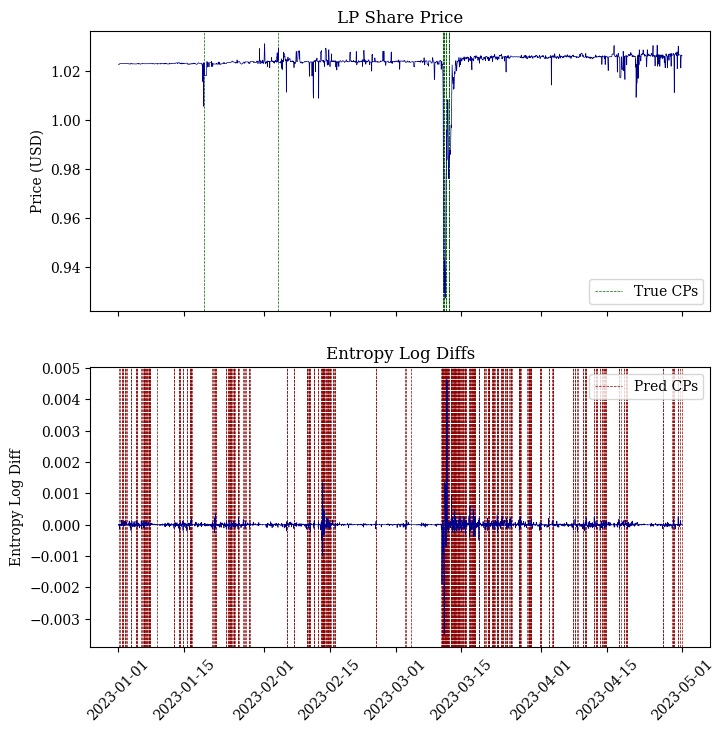

In [96]:
a, b, k = bocd.best_params
bocd.update({'alpha': a, 'beta': b, 'kappa': k})
pred = bocd.predict(X)
bocd_plot_comp(X, port, y.index, pred)

(0.1515151515151515, 1.0, 0.125)


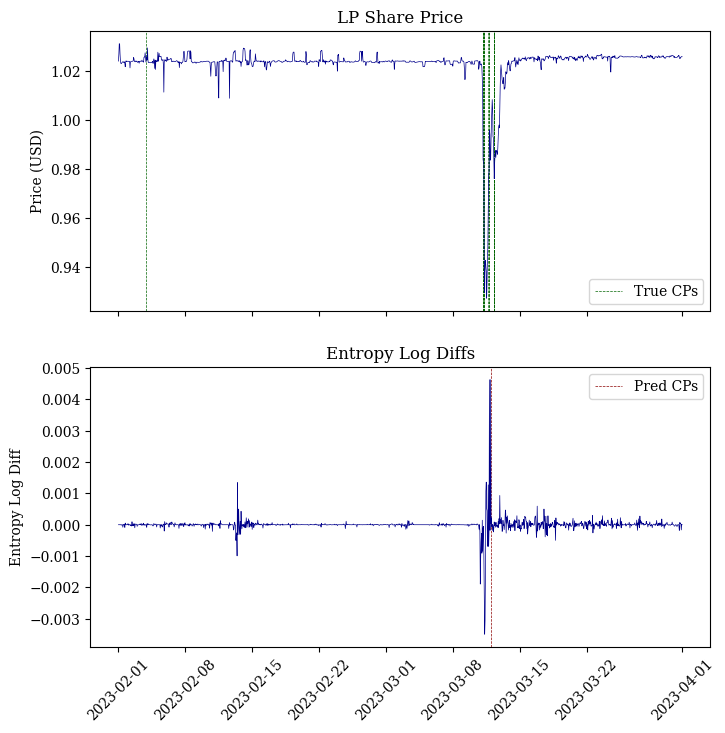

In [ ]:
a, b, k = max(results, key=lambda x: results[x][1])
print(results[(a, b, k)])
pred = predict(metric, {'lambda': 100, 'alpha': a, 'beta': b, 'kappa': k, 'mu': 0})
bocd_plot_comp(metric, port, cps, pred)

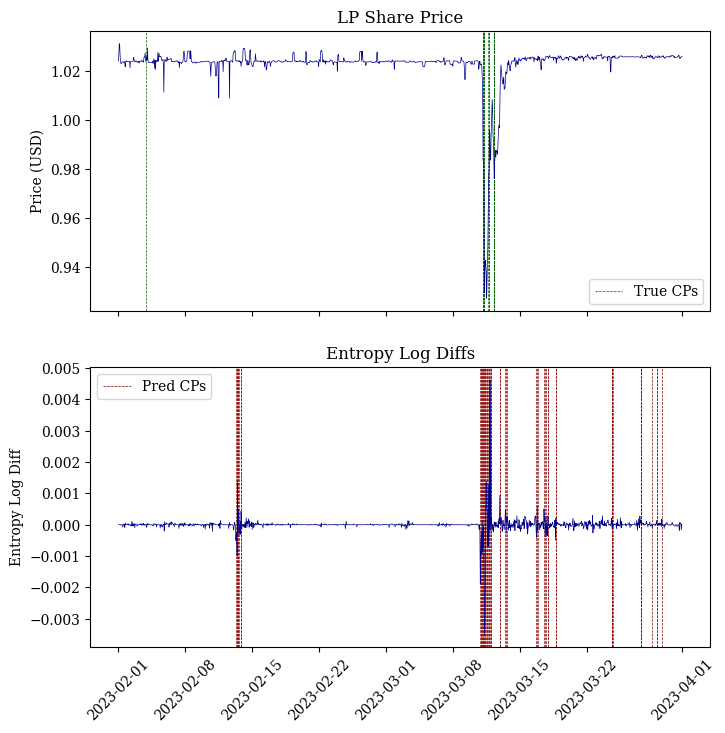

: 

In [ ]:
a, b, k = max(results, key=lambda x: results[x][2])
R, maxes = bocd(metric[:-1], alpha=a, beta=b, kappa=k)
peaks = np.where(maxes[:-1]!=maxes[1:]-1)[0][:-1]
bocd_plot_comp(metric, port, cps, peaks)